# stop-to-stop segments

In [1]:
import geopandas as gpd
import pandas as pd

from update_vars import SEGMENT_GCS, COMPILED_CACHED_VIEWS, analysis_date

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
def attach_shape_id_to_stop_times(analysis_date: str) -> pd.DataFrame:
    """
    Merge stop_times and trips to get shape_id.
    
    Keep unique stop_id-stop_sequence combo at shape-level. 
    """
    stop_times = pd.read_parquet(
        f"{COMPILED_CACHED_VIEWS}st_{analysis_date}.parquet",
        columns = ["feed_key", "trip_id", "stop_id", "stop_sequence"]
    )
    
    trips = pd.read_parquet(
        f"{COMPILED_CACHED_VIEWS}trips_{analysis_date}.parquet", 
        columns = ["feed_key", "trip_id", "shape_id"]
    )
    
    st_with_shape = pd.merge(
        stop_times, 
        trips,
        on = ["feed_key", "trip_id"],
        how = "inner",
        validate = "m:1"
    )
    
    st_by_shape = (st_with_shape.drop_duplicates(
        subset=["feed_key", "shape_id", 
                "stop_id", "stop_sequence"]
         ).drop(columns = "trip_id")
        .sort_values(["feed_key", "shape_id", "stop_sequence"])
        .reset_index(drop=True)
    )
    
    return st_by_shape

In [ ]:
def stop_times_with_stop_geom(analysis_date: str) -> gpd.GeoDataFrame:
    """
    Attach stop's point geometry to stop_times table.
    Use trips in between to get it attached via shape_id.
    
    Keep stop_time's stops at the `shape_id` level.
    """
    stop_times = attach_shape_id_to_stop_times(analysis_date)
    
    stops = gpd.read_parquet(
        f"{COMPILED_CACHED_VIEWS}stops_{analysis_date}.parquet",
        columns = ["feed_key", "stop_id", "stop_name", "geometry"]
    ).drop_duplicates(subset=["feed_key", "stop_id"]).reset_index(drop=True)
    
    gdf = pd.merge(
        stops, 
        stop_times,
        on = ["feed_key", "stop_id"],
        how = "inner",
        validate = "1:m"
    ).sort_values(["feed_key", "shape_id", 
                   "stop_sequence"]
                 ).drop_duplicates(
        subset=["feed_key", "shape_id", "stop_id"]
    ).reset_index(drop=True)
    
    return gdf

In [ ]:
def merge_in_shape_geom_and_project(
    stops: gpd.GeoDataFrame, 
    analysis_date: str
) -> gpd.GeoDataFrame:
    """
    Merge in shape's line geometry.
    shapely.project(x) returns the distance along the line geometry
    nearest the stop point geometry.
    
    From Eric: projecting the stop's point geom onto the shape_id's line geom
    https://github.com/cal-itp/data-analyses/blob/f4c9c3607069da6ea96e70c485d0ffe1af6d7a47/rt_delay/rt_analysis/rt_parser.py#L102-L103
    """
    shapes = gpd.read_parquet(
        f"{COMPILED_CACHED_VIEWS}routelines_{analysis_date}.parquet", 
        columns = ["feed_key", "shape_id", "geometry"]
    )
    
    stops_with_shape = pd.merge(
        stops,
        shapes.rename(columns = {"geometry": "shape_geometry"}),
        on = ["feed_key", "shape_id"],
        how = "inner",
        validate = "m:1"
    )
        
    # Once we merge in shape's line geometry, we can do the project
    # with itertuples, since shapely does it element by element
    # https://gis.stackexchange.com/questions/306838/snap-points-shapefile-to-line-shapefile-using-shapely
    projected = []
    interpolated = []
    
    for row in stops_with_shape.itertuples():
        row_shape_geom = getattr(row, "shape_geometry")
        row_stop_geom = getattr(row, "geometry")
        
        point_projected_along_shape = row_shape_geom.project(row_stop_geom)
        projected.append(point_projected_along_shape)
        
        point_projected_and_interpolated_along_shape = row_shape_geom.interpolate(
            row_shape_geom.project(row_stop_geom))
        interpolated.append(point_projected_and_interpolated_along_shape)
    
    shape_meters_x = [shapely.geometry.Point(i).x for i in interpolated]
    shape_meters_y = [shapely.geometry.Point(i).y for i in interpolated]
    
    stops_with_shape = stops_with_shape.assign(
        shape_meters = projected,
        #shape_meters_interp = shape_meters_interp,
        stop_interpolated = gpd.points_from_xy(shape_meters_x, 
                                               shape_meters_y,
                                               crs = "EPSG:3310")
    )
        
    return stops_with_shape

In [ ]:
#stops = stop_times_with_stop_geom(analysis_date)

In [ ]:
stops_projected = merge_in_shape_geom_and_project(
    stops, analysis_date)

In [ ]:
test_shape_id = "44893"

test_stops_projected = stops_projected[
    stops_projected.shape_id==test_shape_id]

test_stops = stops[stops.shape_id==test_shape_id]

test_stops_projected.to_parquet("./data/test_stops_projected.parquet")
test_stops.to_parquet("./data/test_stops.parquet")

In [2]:
import shapely

test_stops_projected = gpd.read_parquet("./data/test_stops_projected.parquet")
#test_stops = gpd.read_parquet("./data/test_stops.parquet")

In [3]:
break_points = test_stops_projected.stop_interpolated.tolist()
print(break_points)

break_dist = test_stops_projected.shape_meters.tolist()
print(break_dist)


# Construct list of points (interpolated stops)
# into 1 multipoint shapely object
# https://stackoverflow.com/questions/30457089/how-to-create-a-shapely-polygon-from-a-list-of-shapely-points
#multipoint = shapely.geometry.MultiPoint([[p.x, p.y] for p in break_points])

[<shapely.geometry.point.Point object at 0x7f6bea5bc130>, <shapely.geometry.point.Point object at 0x7f6bf00c70d0>, <shapely.geometry.point.Point object at 0x7f6bf00c7130>, <shapely.geometry.point.Point object at 0x7f6bf00c7160>, <shapely.geometry.point.Point object at 0x7f6bf00c72b0>, <shapely.geometry.point.Point object at 0x7f6bea5bc700>, <shapely.geometry.point.Point object at 0x7f6bf80d9fa0>, <shapely.geometry.point.Point object at 0x7f6bfa49e820>, <shapely.geometry.point.Point object at 0x7f6c2edda250>, <shapely.geometry.point.Point object at 0x7f6c2c544280>, <shapely.geometry.point.Point object at 0x7f6c2c5386d0>, <shapely.geometry.point.Point object at 0x7f6c2c538190>, <shapely.geometry.point.Point object at 0x7f6c2c5336a0>, <shapely.geometry.point.Point object at 0x7f6c2c533a00>, <shapely.geometry.point.Point object at 0x7f6bf00c7070>, <shapely.geometry.point.Point object at 0x7f6bf00c7370>, <shapely.geometry.point.Point object at 0x7f6bf00c7310>, <shapely.geometry.point.Point 

In [4]:
test_geom = test_stops_projected.shape_geometry.iloc[0]

In [ ]:
from shapely.geometry import LineString, Point

def cut(line, distance, lines):
    # Cuts a line in several segments at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        
        if pd == distance:
            return [
                 LineString(coords[:i+1]),
                 LineString(coords[i:])
                 ]
        if pd > distance:
            cp = line.interpolate(distance)
            lines.append(LineString(coords[:i] + [(cp.x, cp.y)]))
            line = LineString([(cp.x, cp.y)] + coords[i:])
            
            if line.length > distance:
                cut(line, distance, lines)
            else:
                lines.append(LineString([(cp.x, cp.y)] + coords[i:]))
                
            return lines

In [ ]:
#https://gis.stackexchange.com/questions/210220/break-a-shapely-linestring-at-multiple-points

In [5]:
# https://gis.stackexchange.com/questions/203048/split-lines-at-points-using-shapely/203068#203068
# First coords of line (start + end)
coords = [test_geom.coords[0], test_geom.coords[-1]] 
print(coords)

[(-131169.64161250877, 73212.3800774184), (-129323.13925001225, 59407.944659579545)]


In [8]:
# Add the coords from the points
# from break_points, we need to access the coords, and then grab [0] for the tuple
break_points_coords = [i.coords[0] for i in break_points]
coords = coords + break_points_coords
print(coords)

[(-131169.64161250877, 73212.3800774184), (-129323.13925001225, 59407.944659579545), (-131111.52998930117, 73198.85092050997), (-131444.7698093721, 72367.75665354103), (-131445.7505398213, 72101.82143741498), (-131394.72572753768, 71653.25886234487), (-131197.47056145588, 71064.75928984882), (-131091.91500750795, 70351.38920295957), (-130871.33427696743, 70149.71965504675), (-130255.43791576795, 68903.13794142558), (-130263.21552291926, 68418.26415792928), (-130266.09926964728, 68228.38667298632), (-130269.4353780544, 67974.56224965678), (-130271.81820200194, 67756.33282285434), (-130279.1757972755, 67235.61133171602), (-130282.49472943495, 66899.21526011152), (-130671.02205159348, 65608.1441362678), (-130245.03073028236, 65596.95862823445), (-129980.91289461429, 65533.39676630959), (-130183.54055113584, 64164.88090622461), (-130223.92753760147, 64052.050376806335), (-130274.9990009064, 63898.47287172286), (-130447.1558114303, 63424.24933777994), (-130521.0213515602, 63215.559659017985

In [9]:
dists = [test_geom.project(shapely.geometry.Point(p)) for p in coords]

In [10]:
coords = [p for (d, p) in sorted(zip(break_dist, coords))]

In [16]:
coords[:5]

[(-131169.64161250877, 73212.3800774184),
 (-129323.13925001225, 59407.944659579545),
 (-131111.52998930117, 73198.85092050997),
 (-131444.7698093721, 72367.75665354103),
 (-131445.7505398213, 72101.82143741498)]

In [12]:
lines = [shapely.geometry.LineString([coords[i], coords[i+1]]) 
         for i in range(len(coords)-1)]

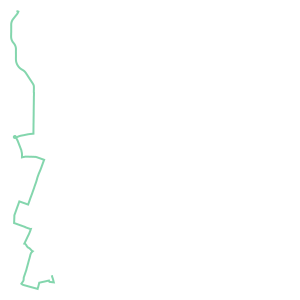

In [17]:
test_geom

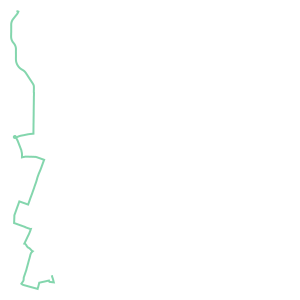

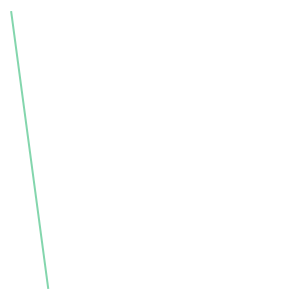

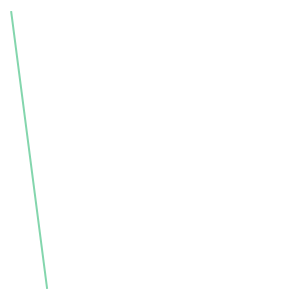

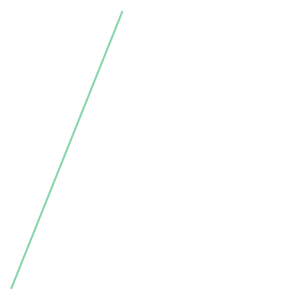

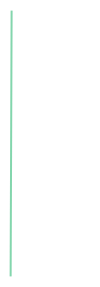

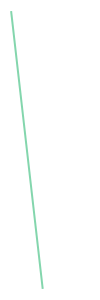

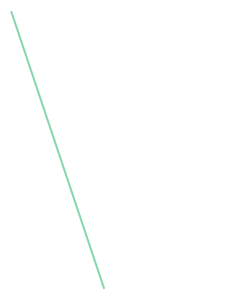

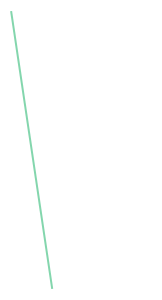

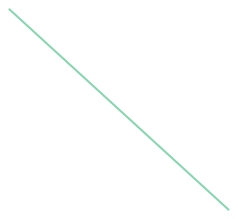

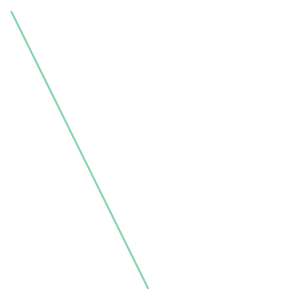

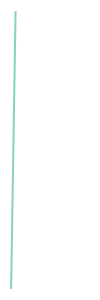

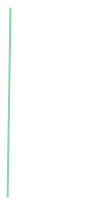

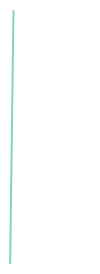

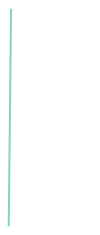

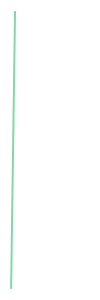

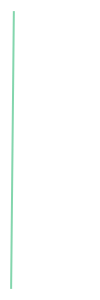

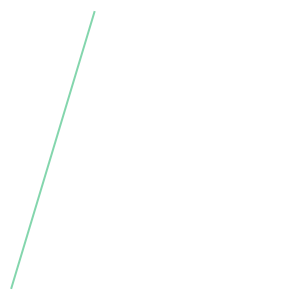

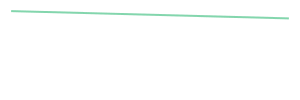

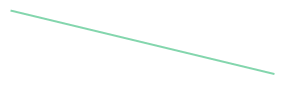

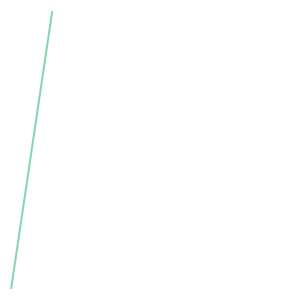

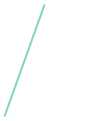

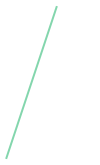

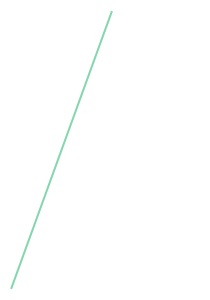

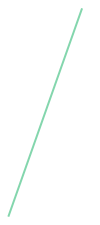

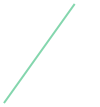

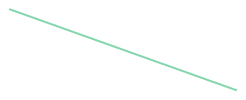

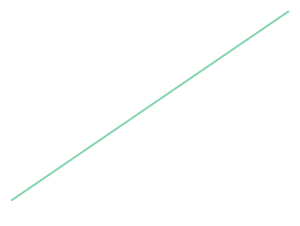

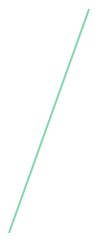

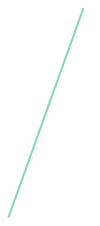

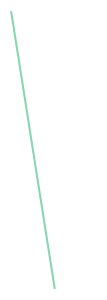

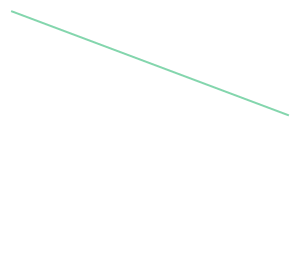

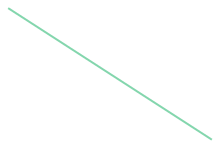

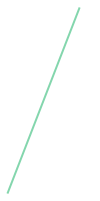

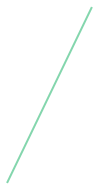

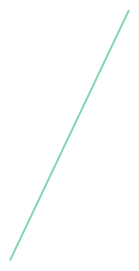

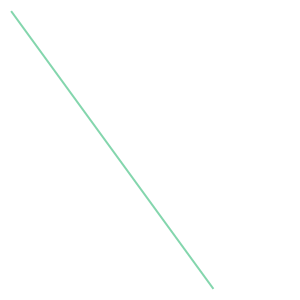

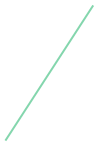

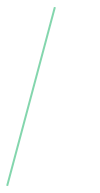

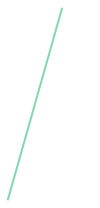

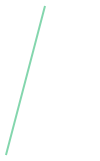

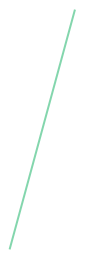

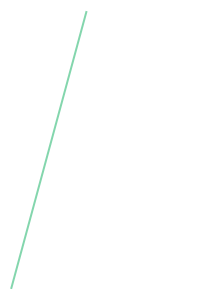

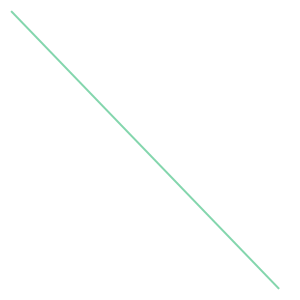

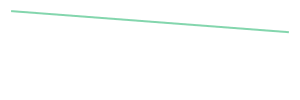

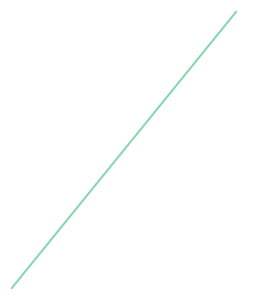

In [15]:
for i in lines:
    display(i)

* https://gis.stackexchange.com/questions/203048/split-lines-at-points-using-shapely
* https://stackoverflow.com/questions/31072945/shapely-cut-a-piece-from-a-linestring-at-two-cutting-points
* https://gis.stackexchange.com/questions/210220/break-a-shapely-linestring-at-multiple-points
* https://gis.stackexchange.com/questions/416284/splitting-multiline-or-linestring-into-equal-segments-of-particular-length-using